In [1]:
pwd = 'C:/Users/samar/OneDrive/Desktop/UVA/Stochastic Hydrology'

# Developed in other notebook
lex_db = './lexicons.db'

# text_db = '../2019-02-21_Lab06/moby.db'
OHCO = [ 'para_id', 'sent_id', 'token_id']
#CHAPS = OHCO[:1]
PARAS = OHCO[:1]
SENTS = OHCO[:2]

# emo = 'bing_sentiment'
emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import sys
import scipy.fftpack as fftpack
from sklearn.neighbors import KernelDensity as KDE
from sklearn.preprocessing import scale

import sqlite3
import sys
sys.path.insert(0, pwd)
import textman as tx
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

In [4]:
%cd {pwd}

%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

C:\Users\samar\OneDrive\Desktop\UVA\Stochastic Hydrology


In [5]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.75,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.50,NaN
abandoner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-0.25,-1.0
abandons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,NaN


In [6]:
emo_cols = combo.columns

In [7]:
#This can be used to sentiment analysis on individual coal or gas files.
#There are 11 files of each, change the number of the name to perform Sentiment Analysis on other file.
text_df_coal=tx.import_source('{}/Data_Initial/Coal/coal_final_7.txt'.format(pwd),col_name='para',id_name='para_id',strip=False)

tokens,vocabs=tx.create_tokens_and_vocab(text_df_coal,idx=['para_id','sent_id'],src_col='para')
tokens.head()

src_file C:/Users/samar/OneDrive/Desktop/UVA/Stochastic Hydrology/Data_Initial/Coal/coal_final_7.txt


token term_str  term_id
para_id sent_id token_id                          
0       0       10        Easter   easter       16
        1       2         Easter   easter       16
        2       1         Easter   easter       16

In [8]:
FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
FIG

{'figsize': (25, 5), 'legend': True, 'fontsize': 14, 'rot': 45}

In [9]:
tokens = tokens.join(combo, on='term_str', how='left')
#tokens[emo].sample(10)
#Not looking great.
#Very few Tokens. The data files are too small. May have to change the data for further analysis.

In [10]:
tokens.head()

token term_str  term_id  nrc_anger  \
para_id sent_id token_id                                        
0       0       10        Easter   easter       16        NaN   
        1       2         Easter   easter       16        NaN   
        2       1         Easter   easter       16        NaN   

                          nrc_anticipation  nrc_disgust  nrc_fear  nrc_joy  \
para_id sent_id token_id                                                     
0       0       10                     NaN          NaN       NaN      NaN   
        1       2                      NaN          NaN       NaN      NaN   
        2       1                      NaN          NaN       NaN      NaN   

                          nrc_negative  nrc_positive  nrc_sadness  \
para_id sent_id token_id                                            
0       0       10                 NaN           NaN          NaN   
        1       2                  NaN           NaN          NaN   
        2       1                  NaN           NaN          NaN   

                          nrc_surprise  nrc_trust  bing_negative  \
para_id sent_id token_id                                           
0       0       10                 NaN        NaN            NaN   
        1       2                  NaN        NaN            NaN   
        2       1                  NaN        NaN            NaN   

                          bing_positive  bing_sentiment  syu_sentiment  \
para_id sent_id token_id                                                 
0       0       10                  NaN             NaN            NaN   
        1       2                   NaN             NaN            NaN   
        2       1                   NaN             NaN            NaN   

                          gi_sentiment  
para_id sent_id token_id                
0       0       10                 NaN  
        1       2                  NaN  
        2       1                  NaN

C:\Users\samar\Anaconda3\lib\site-packages\pandas\plotting\_core.py:998: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


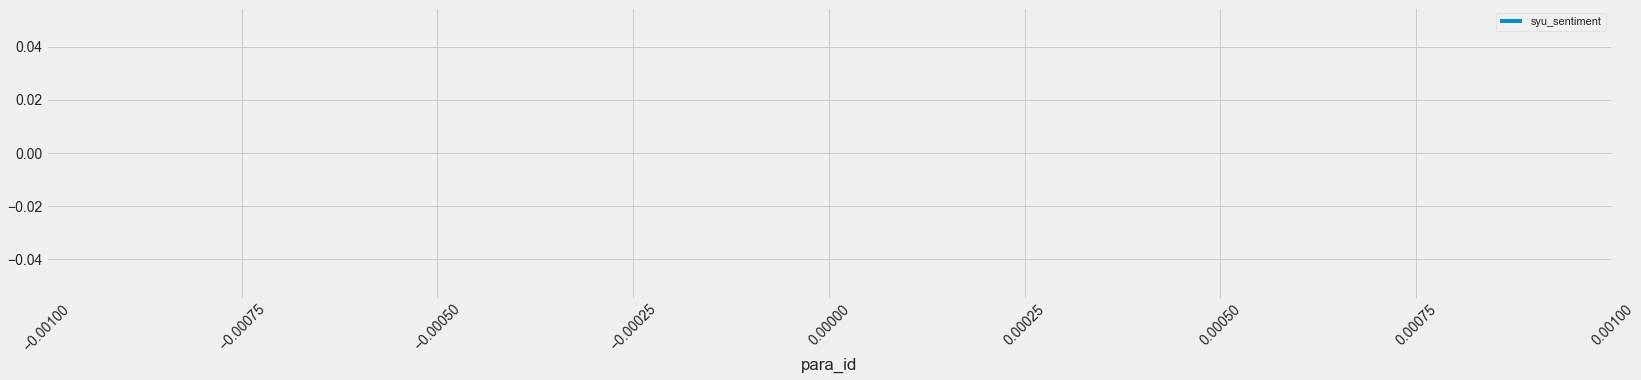

In [11]:
tokens.groupby(PARAS)[emo].sum().plot(**FIG)
tokens[emo_cols] = tokens[emo_cols].fillna(0)

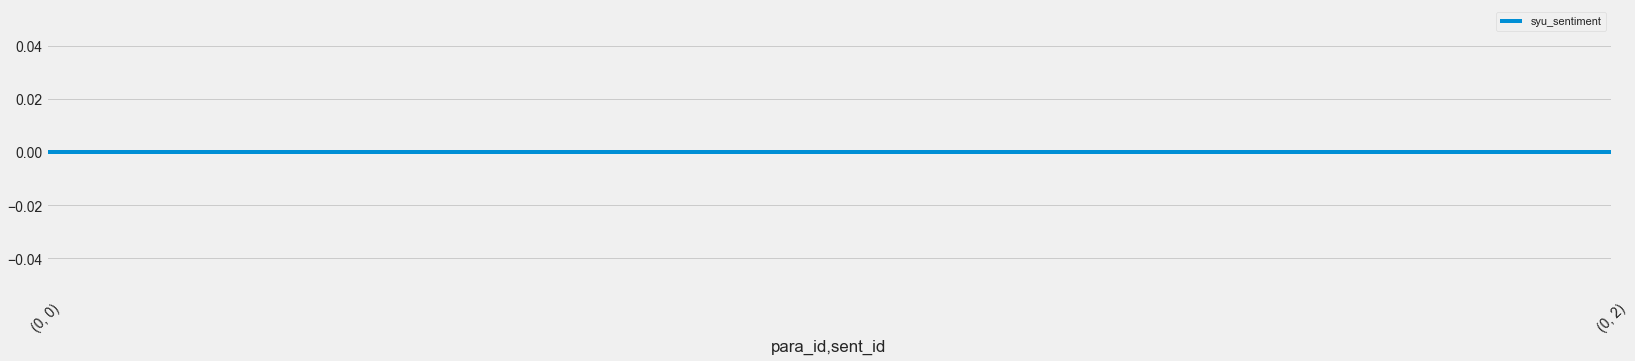

In [12]:
by_sent = tokens.groupby(SENTS)[emo_cols].sum()
max_x = by_sent.shape[0]
xticks = list(range(0, max_x, 250))
xticks.append(max_x - 1)
by_sent[emo].plot(**FIG, xticks=xticks)

In [13]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token), 1)
tokens['html'].head()


para_id  sent_id  token_id
0        0        10          <span class='sent0'>Easter</span>
         1        2           <span class='sent0'>Easter</span>
         2        1           <span class='sent0'>Easter</span>
Name: html, dtype: object

In [14]:
by_sent['sent_str'] = tokens.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_sent['html_str'] = tokens.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))

In [15]:
by_sent[['sent_str', 'html_str']].head()

sent_str                           html_str
para_id sent_id                                            
0       0         easter  <span class='sent0'>Easter</span>
        1         easter  <span class='sent0'>Easter</span>
        2         easter  <span class='sent0'>Easter</span>

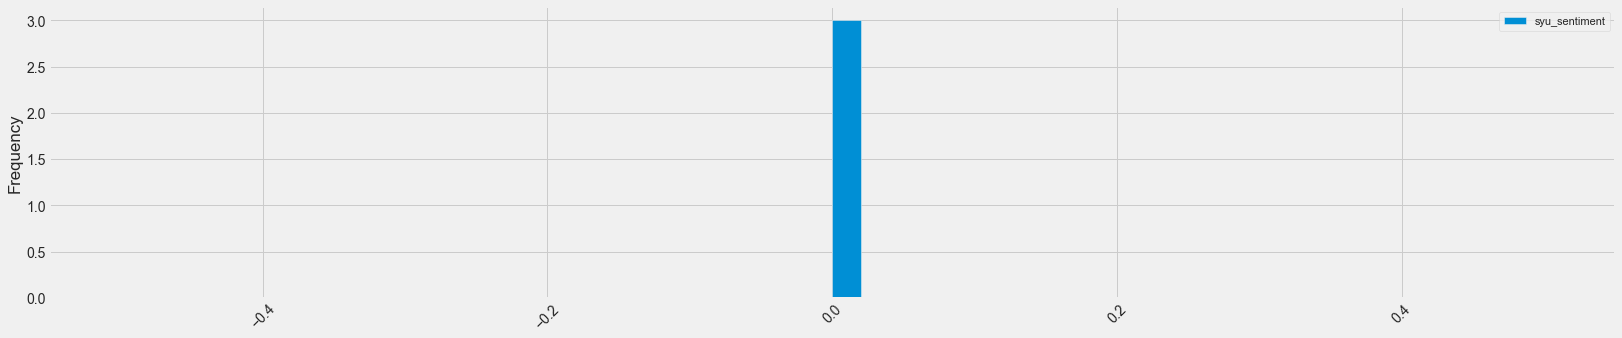

In [16]:
by_sent[emo].plot.hist(**FIG, bins=50)
#This clearly shows the graphs are not great.
#Though it shows the sentiment here is zero which kind of aligns with the paper as well as the emotional valence
#of the data described in the paper was zero too.

In [17]:
text_df_oil=tx.import_source('{}/Data_Initial/Oil/oil_final_1.txt'.format(pwd),col_name='para',id_name='para_id',strip=False)

tokens,vocabs=tx.create_tokens_and_vocab(text_df_oil,idx=['para_id','sent_id'],src_col='para')
tokens
#Here also very few terms
#CLearly it shows that the data is not great.

src_file C:/Users/samar/OneDrive/Desktop/UVA/Stochastic Hydrology/Data_Initial/Oil/oil_final_1.txt


token  term_str  term_id
para_id sent_id token_id                             
0       3       6          America   america        2
                20         country   country       21
        4       21             new       new       80
                25        refinery  refinery       96
        5       2              new       new       80
                11         country   country       21
                18         America   america        2
        6       1            Brian     brian       10
                7           career    career       16
        7       16           world     world      137
        8       2            Brian     brian       10
                15           Brian     brian       10
                27          career    career       16
        9       7            Brian     brian       10
                22             new       new       80
                24        refinery  refinery       96
        10      1            Brian     brian       10
                8            world     world      137
                14        refinery  refinery       96
        11      1            Brian     brian       10
                11         country   country       21
        12      5           career    career       16
                10           world     world      137
                17         America   america        2

In [18]:
tokens = tokens.join(combo, on='term_str', how='left')
tokens

token  term_str  term_id  nrc_anger  \
para_id sent_id token_id                                           
0       3       6          America   america        2        NaN   
                20         country   country       21        NaN   
        4       21             new       new       80        NaN   
                25        refinery  refinery       96        NaN   
        5       2              new       new       80        NaN   
                11         country   country       21        NaN   
                18         America   america        2        NaN   
        6       1            Brian     brian       10        NaN   
                7           career    career       16        0.0   
        7       16           world     world      137        NaN   
        8       2            Brian     brian       10        NaN   
                15           Brian     brian       10        NaN   
                27          career    career       16        0.0   
        9       7            Brian     brian       10        NaN   
                22             new       new       80        NaN   
                24        refinery  refinery       96        NaN   
        10      1            Brian     brian       10        NaN   
                8            world     world      137        NaN   
                14        refinery  refinery       96        NaN   
        11      1            Brian     brian       10        NaN   
                11         country   country       21        NaN   
        12      5           career    career       16        0.0   
                10           world     world      137        NaN   
                17         America   america        2        NaN   

                          nrc_anticipation  nrc_disgust  nrc_fear  nrc_joy  \
para_id sent_id token_id                                                     
0       3       6                      NaN          NaN       NaN      NaN   
                20                     NaN          NaN       NaN      NaN   
        4       21                     NaN          NaN       NaN      NaN   
                25                     NaN          NaN       NaN      NaN   
        5       2                      NaN          NaN       NaN      NaN   
                11                     NaN          NaN       NaN      NaN   
                18                     NaN          NaN       NaN      NaN   
        6       1                      NaN          NaN       NaN      NaN   
                7                      1.0          0.0       0.0      0.0   
        7       16                     NaN          NaN       NaN      NaN   
        8       2                      NaN          NaN       NaN      NaN   
                15                     NaN          NaN       NaN      NaN   
                27                     1.0          0.0       0.0      0.0   
        9       7                      NaN          NaN       NaN      NaN   
                22                     NaN          NaN       NaN      NaN   
                24                     NaN          NaN       NaN      NaN   
        10      1                      NaN          NaN       NaN      NaN   
                8                      NaN          NaN       NaN      NaN   
                14                     NaN          NaN       NaN      NaN   
        11      1                      NaN          NaN       NaN      NaN   
                11                     NaN          NaN       NaN      NaN   
        12      5                      1.0          0.0       0.0      0.0   
                10                     NaN          NaN       NaN      NaN   
                17                     NaN          NaN       NaN      NaN   

                          nrc_negative  nrc_positive  nrc_sadness  \
para_id sent_id token_id                                            
0       3       6                  NaN           NaN          NaN   
                20      

C:\Users\samar\Anaconda3\lib\site-packages\pandas\plotting\_core.py:998: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


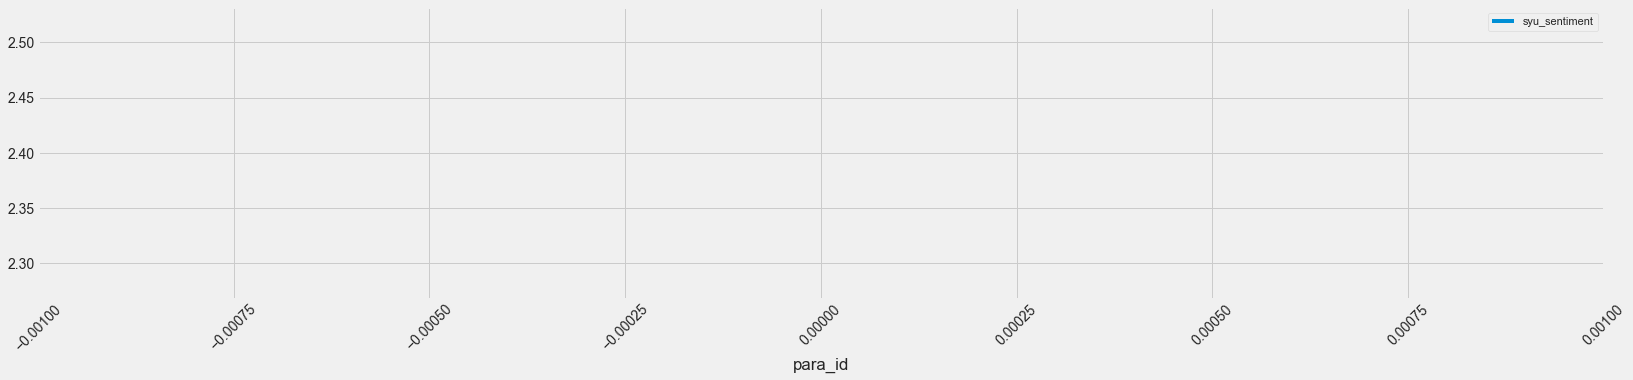

In [19]:
tokens.groupby(PARAS)[emo].sum().plot(**FIG)
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [20]:
rows = []
for idx in by_sent.sample(10).index:
    
    valence = round(by_sent.loc[idx, emo], 4)     
    t = 0
    if valence > t: color = '#ccffcc'
    elif valence < t: color = '#ffcccc'
    else: color = '#f2f2f2'
    z=0
    rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
    <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
    </tr>""".format(color, valence, by_sent.loc[idx, 'html_str'], idx))
    
display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

ValueError: Cannot take a larger sample than population when 'replace=False'

In [21]:
xticks = [0]
xticks += by_sent[emo].reset_index().sort_values(emo).head(7).index.values.tolist()
xticks += by_sent[emo].reset_index().sort_values(emo).tail(7).index.values.tolist()
xticks += [by_sent.shape[0] - 1]

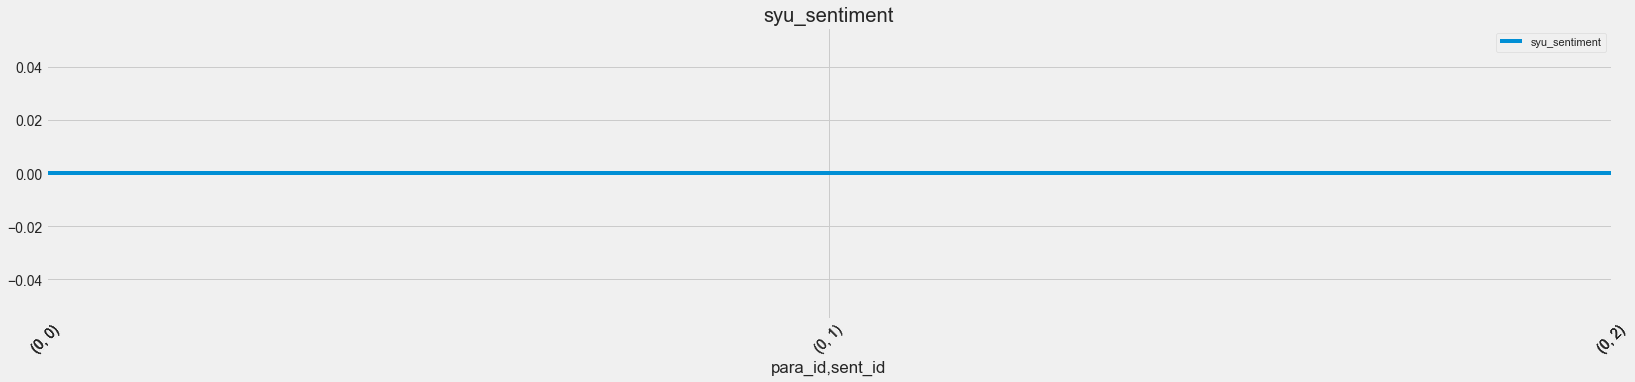

In [22]:
by_sent[emo].plot(**FIG, xticks=xticks, title=emo)

In [23]:
by_sent.iloc[xticks][emo].sort_index().to_frame()
#clearly very poor results. hence I changed the data.
#Final data is from a journal and are research and/or review papers written on Coal and Shale Gas.
#The papers are written in the last 3-4 years.

syu_sentiment
para_id sent_id               
0       0                  0.0
        0                  0.0
        0                  0.0
        1                  0.0
        1                  0.0
        2                  0.0
        2                  0.0
        2                  0.0

In [32]:
text_df_coal=tx.import_source('{}/Data_Final/Coal_Final/Coal-1.txt'.format(pwd),col_name='para',id_name='para_id',strip=False)

tokens,vocabs=tx.create_tokens_and_vocab(text_df_coal,idx=['para_id','sent_id'],src_col='para')
tokens.head()

src_file C:/Users/samar/OneDrive/Desktop/UVA/Stochastic Hydrology/Data_Final/Coal_Final/Coal-1.txt


token    term_str  term_id
para_id sent_id token_id                                 
0       0       5         coalmining  coalmining      444
                6         opposition  opposition     1388
                9              Czech       czech      582
                10          Republic    republic     1696
                12           country     country      555

In [33]:
tokens = tokens.join(combo, on='term_str', how='left')


In [34]:
tokens[emo].sample(10)

para_id  sent_id  token_id
39       1        11          NaN
4        7        0           NaN
88       3        7           NaN
2        30       25         -0.5
1        6        27          0.5
47       1        19          NaN
0        0        10          NaN
45       1        3           NaN
2        46       19          0.8
62       0        32          NaN
Name: syu_sentiment, dtype: float64

In [37]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [39]:
FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)

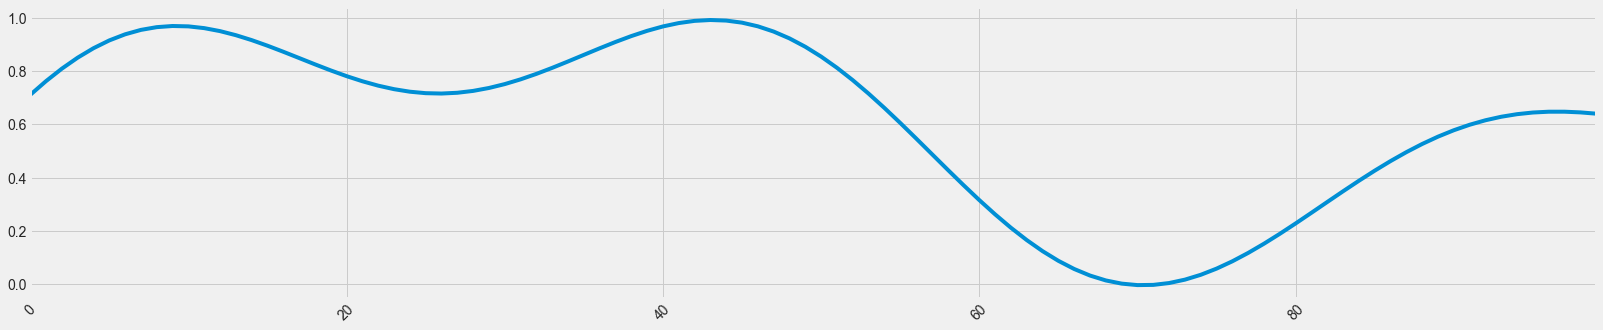

In [280]:
FIG['legend'] = False
pd.Series(X).plot(**FIG)

### By Paragraphs

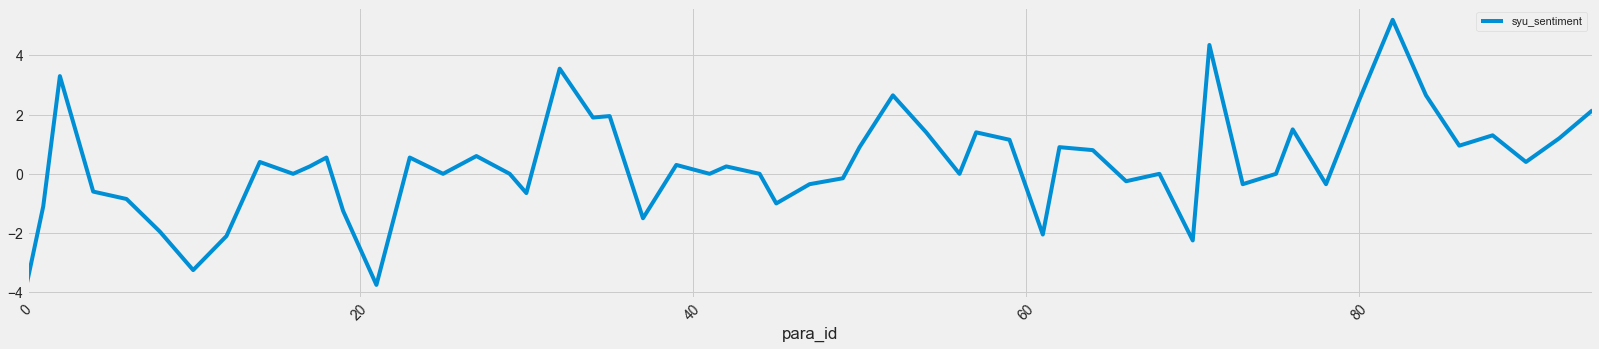

In [41]:
tokens.groupby(PARAS)[emo].sum().plot(**FIG)

### By Sentence

In [43]:
by_sent = tokens.groupby(SENTS)[emo_cols].sum()

In [45]:
max_x = by_sent.shape[0]
xticks = list(range(0, max_x, 250))
xticks.append(max_x - 1)

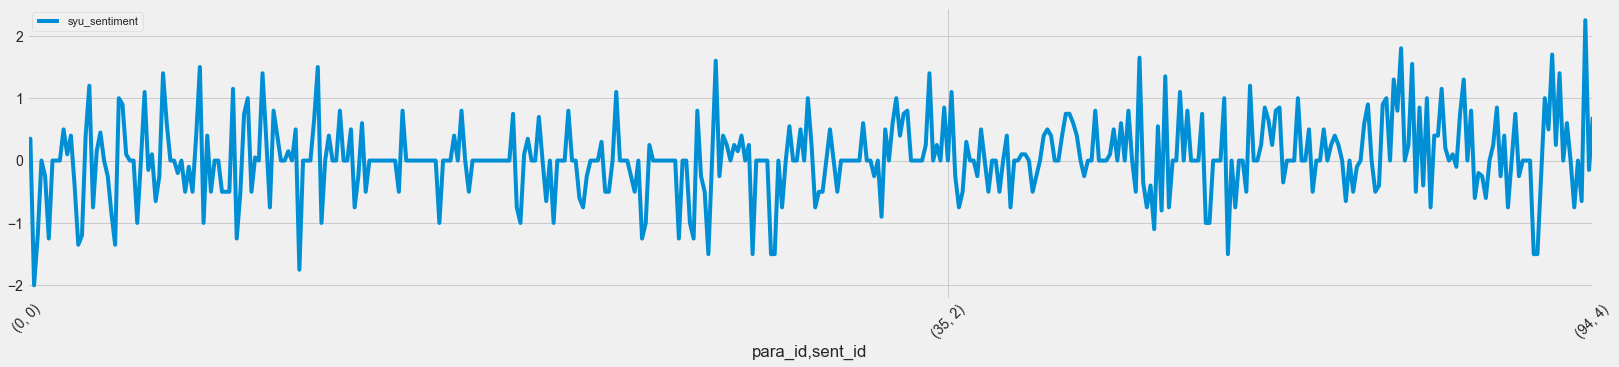

In [46]:
by_sent[emo].plot(**FIG, xticks=xticks)
#has a nice mix of positive and negative as well

### Add text to do spot checks

In [50]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token), 1)

In [51]:
tokens['html'].head()

para_id  sent_id  token_id
0        0        5            <span class='sent0'>coalmining</span>
                  6           <span class='sent-1'>opposition</span>
                  9                 <span class='sent0'>Czech</span>
                  10             <span class='sent0'>Republic</span>
                  12              <span class='sent0'>country</span>
Name: html, dtype: object

In [52]:
by_sent['sent_str'] = tokens.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_sent['html_str'] = tokens.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))

In [53]:
by_sent[['sent_str', 'html_str']].head()

sent_str  \
para_id sent_id                                                      
0       0        coalmining opposition czech republic country s...   
        1        czech government established called territoria...   
        2        limits conflict proponents mining reserves bey...   
        3        discursive level conflict members opposition m...   
        4        based interviews three frames emerged local im...   

                                                          html_str  
para_id sent_id                                                     
0       0        <span class='sent0'>coalmining</span> <span cl...  
        1        <span class='sent0'>Czech</span> <span class='...  
        2        <span class='sent-1'>limits</span> <span class...  
        3        <span class='sent0'>discursive</span> <span cl...  
        4        <span class='sent0'>Based</span> <span class='...

### Histogram

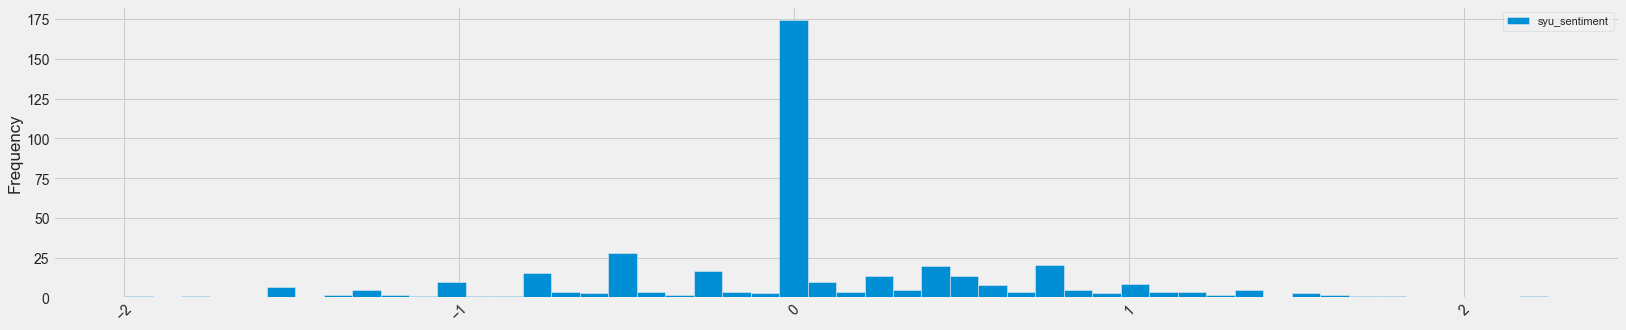

In [54]:
by_sent[emo].plot.hist(**FIG, bins=50)
#Can be considered as negative

### Look at a sample of sentences

In [55]:
rows = []
for idx in by_sent.sample(10).index:
    
    valence = round(by_sent.loc[idx, emo], 4)     
    t = 0
    if valence > t: color = '#ccffcc'
    elif valence < t: color = '#ffcccc'
    else: color = '#f2f2f2'
    z=0
    rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
    <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
    </tr>""".format(color, valence, by_sent.loc[idx, 'html_str'], idx))
    
display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

Sentiment,ID,Sentence
-0.25,"(8, 2)",Reserves beyond limits still considered
0.0,"(2, 107)",frames discussed within research team
0.6,"(52, 9)",mining incentives state also essential
1.0,"(1, 15)",approach proponents largely built local costs benefits
-0.25,"(92, 0)",Regarding second research question results several discursive cleavages within opposition coal mining
0.0,"(19, 5)",Politicians keep industrial country citizens health
-1.0,"(2, 3)",NIMBY opposition even opposition specific projects
-0.25,"(1, 26)",active opposition movement coal mining frame
0.75,"(86, 4)",climate change issue coal limits debate due environmental NGOs broader focus
-0.1,"(86, 3)",Instead attention environmental degradation impacts local level


### Plot with Xticks

In [56]:
xticks = [0]
xticks += by_sent[emo].reset_index().sort_values(emo).head(7).index.values.tolist()
xticks += by_sent[emo].reset_index().sort_values(emo).tail(7).index.values.tolist()
xticks += [by_sent.shape[0] - 1]

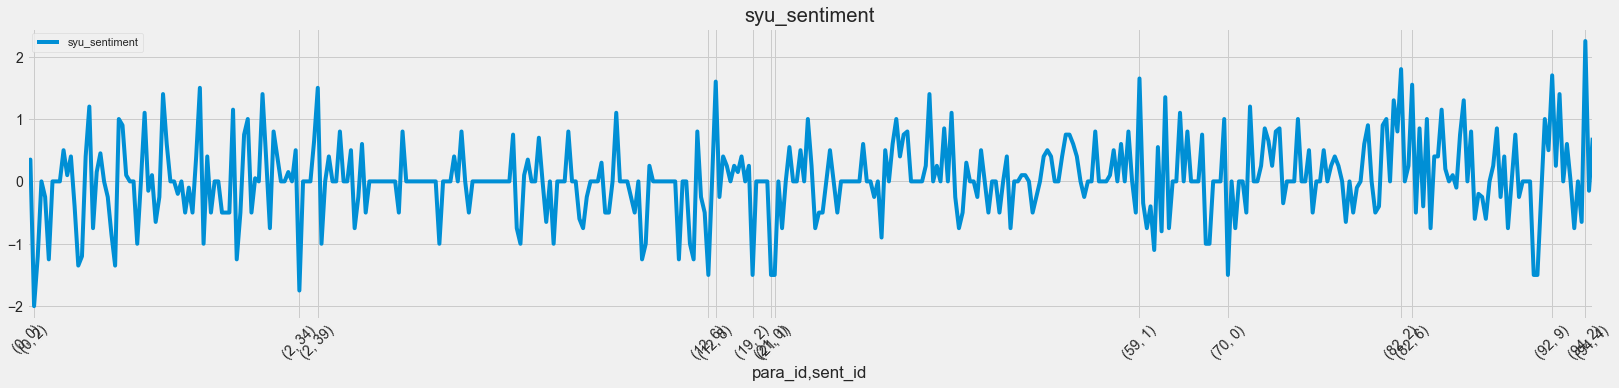

In [57]:
by_sent[emo].plot(**FIG, xticks=xticks, title=emo)

In [58]:
by_sent.iloc[xticks][emo].sort_index().to_frame()

syu_sentiment
para_id sent_id               
0       0                 0.10
        2                -2.00
2       34               -1.75
        39                1.50
12      6                -1.50
        8                 1.60
19      2                -1.50
21      0                -1.50
        1                -1.50
59      1                 1.65
70      0                -1.50
82      2                 1.80
        6                 1.55
92      9                 1.70
94      2                 2.25
        4                 0.70

### Inspect Positives

In [59]:
by_sent.sort_values(emo, ascending=False)[[emo,'sent_str']].head(20)

syu_sentiment  \
para_id sent_id                  
94      2                 2.25   
82      2                 1.80   
92      9                 1.70   
59      1                 1.65   
12      8                 1.60   
82      6                 1.55   
2       39                1.50   
        2                 1.50   
1       27                1.40   
92      11                1.40   
2       22                1.40   
34      5                 1.40   
62      1                 1.35   
82      0                 1.30   
88      0                 1.30   
71      2                 1.20   
1       6                 1.20   
84      8                 1.15   
2       11                1.15   
35      5                 1.10   

                                                          sent_str  
para_id sent_id                                                     
94      2        substantial achieve situation could benefit li...  
82      2        consistent broader governance political partic...  
92      9        consistent concept activism emerged post commu...  
59      1        campaigns environmental ngos resources high we...  
12      8        seems new status quo politicians power questio...  
82      6        building coalition environmental ngos movement...  
2       39       context research environmental framing coal mi...  
        2        phenomenon result rational actions individual ...  
1       27        understanding frames established several reasons  
92      11       line new social movements focus thus political...  
2       22       shared values groups including environmental a...  
34      5        identified national environmental ngos essenti...  
62      1        approach growth primary goal consumption earth...  
82      0        resist shared state including regarding citize...  
88      0        since substantial part environmental sector mo...  
71      2                        want provide information lobbying  
1       6        understanding case opposition open pit coal mi...  
84      8        direct action considered last resort option po...  
2       11             sense concept actions result actors benefit  
35      5                         need build community level among

### Inspect Negatives

In [61]:
#Transforms
def get_transformed_values(raw_values, low_pass_size = 2, x_reverse_len = 100,  padding_factor = 2, scale_values = False, scale_range = False):

    if low_pass_size > len(raw_values):
        sys.exit("low_pass_size must be less than or equal to the length of raw_values input vector")

    raw_values_len = len(raw_values)
    padding_len = raw_values_len * padding_factor

    # Add padding, then fft
    values_fft = fftpack.fft(raw_values, padding_len)
    low_pass_size = low_pass_size * (1 + padding_factor)
    keepers = values_fft[:low_pass_size]

    # Preserve frequency domain structure
    modified_spectrum = list(keepers) \
        + list(np.zeros((x_reverse_len * (1+padding_factor)) - (2*low_pass_size) + 1)) \
        + list(reversed(np.conj(keepers[1:(len(keepers))])))
    
    
    # Strip padding
    inverse_values = fftpack.ifft(modified_spectrum)
    inverse_values = inverse_values[:x_reverse_len]

#     transformed_values = np.real(tuple(inverse_values))
    transformed_values = np.real(inverse_values)
    return transformed_values

In [62]:
FFTCFG = dict(
    low_pass_size = 3,
    x_reverse_len = 100,
    padding_factor = 2
)
X = get_transformed_values(by_sent[emo].values, **FFTCFG)

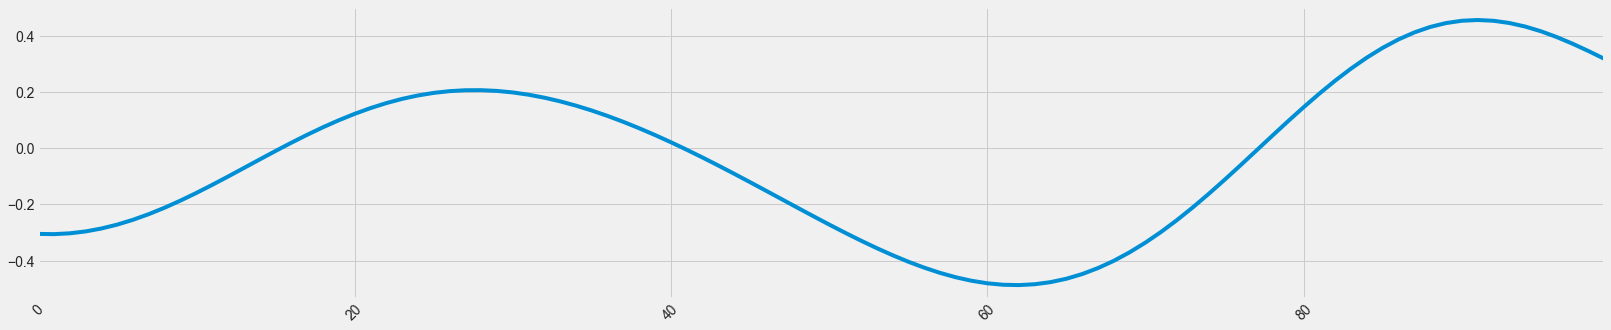

In [63]:
FIG['legend'] = False
pd.Series(X).plot(**FIG)

In [65]:
def get_dct_transform(raw_values, low_pass_size = 5, x_reverse_len = 100):
    if low_pass_size > len(raw_values):
        raise ValueError("low_pass_size must be less than or equal to the length of raw_values input vector")
    values_dct = fftpack.dct(raw_values, type = 2)
    keepers = values_dct[:low_pass_size]
    padded_keepers = list(keepers) + list(np.zeros(x_reverse_len - low_pass_size))
    dct_out = fftpack.idct(padded_keepers)
    return(dct_out) 
#dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
#FIG

In [66]:
FFTCFG1 = dict(
    low_pass_size = 5,
    x_reverse_len = 100
)
X1 = get_dct_transform(by_sent[emo].values, **FFTCFG1)

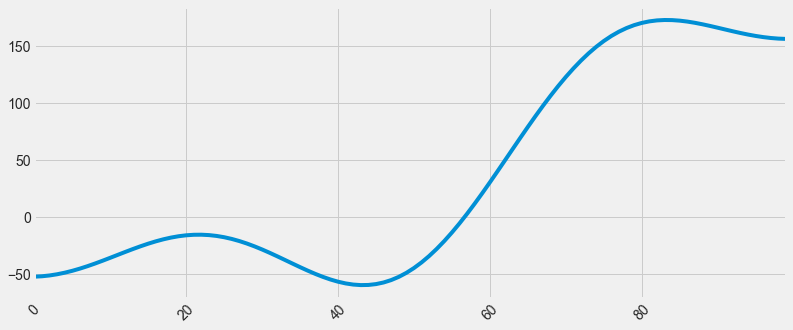

In [67]:
FIG['figsize'] = (12,5)
pd.Series(X1).plot(**FIG)

### Using Rolling
**Window types**: 
boxcar
triang
blackman
hamming
bartlett
parzen
bohman
blackmanharris
nuttall
barthann
kaiser (needs beta)
gaussian (needs std)
general_gaussian (needs power, width)
slepian (needs width).

In [70]:
# Config for tokens
CFG2 = dict(
    win_type='triang',
    window= int(tokens.shape[0]/ 9),
    center=True
)
CFG2['window']

271

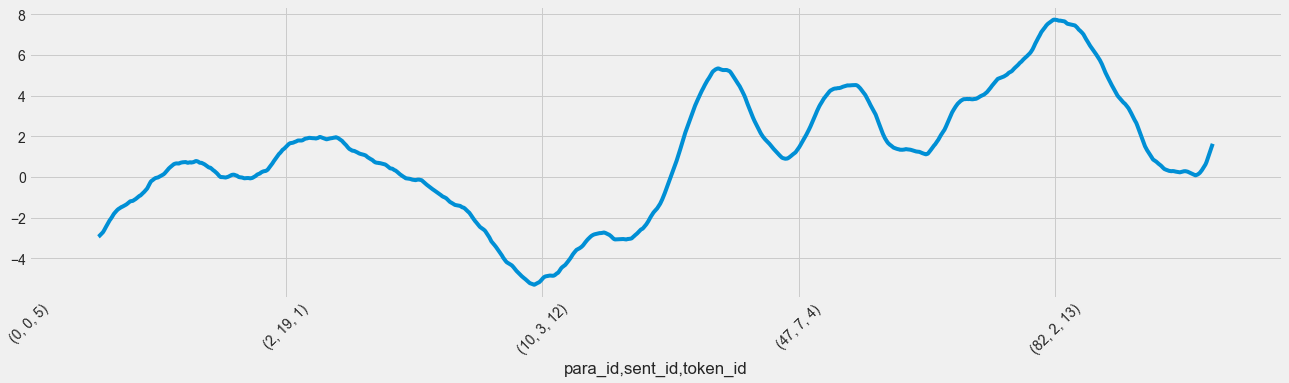

In [71]:
tokens[emo].fillna(0).rolling(**CFG2).sum().plot(**FIG)

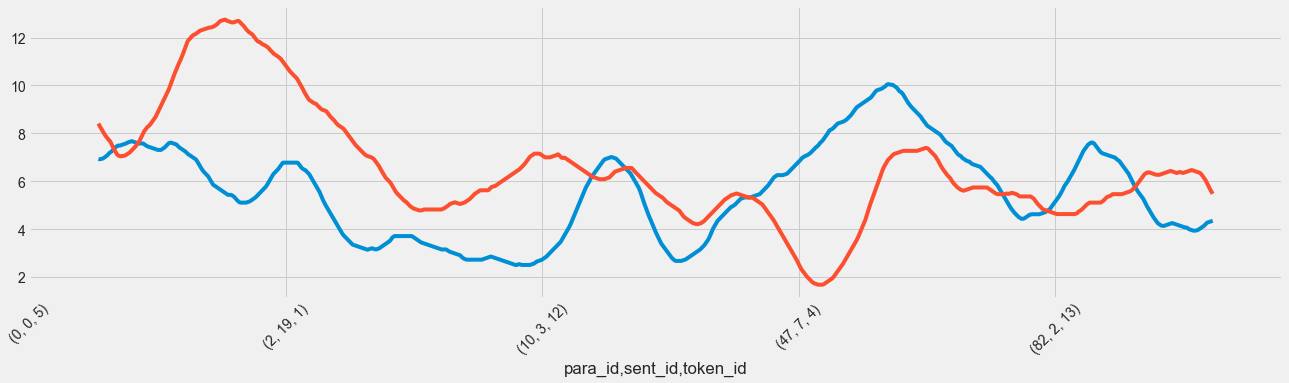

In [72]:
tokens[['nrc_positive','nrc_negative']].rolling(**CFG2).sum().plot(**FIG)

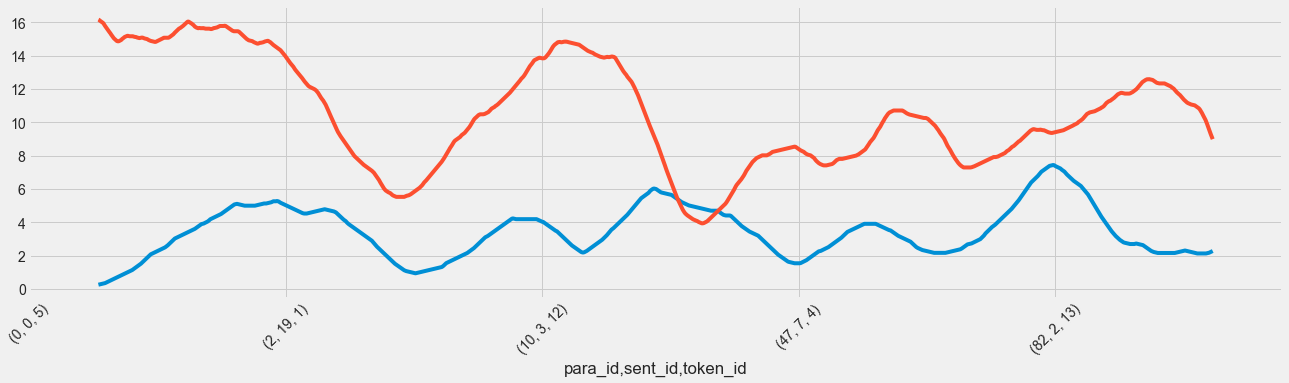

In [73]:
tokens[['bing_positive','bing_negative']].fillna(0).rolling(**CFG2).sum().plot(**FIG)